In [417]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

In [418]:
df = pd.read_csv('data.csv')

In [419]:
# replace missing data ('\N') with NaN
df = df.replace(r'\N', np.nan)

# drop some uninteresting columns
df = df.drop(columns=['movie_id', 'duration', 'description', 'reason', 'datePublished', 'production_company',
                      'poster', 'director', 'director_id', 'staffs', 'staff_names', 'staff_ids', 'actors', 'actor_ids',
                      'reviews', 'reviewers'])

# replace the missing data of winners/nominees with 'None' string
df = df.fillna(value={'winners': 'None', 'nominees': 'None'})

# remove incomplete rows
df = df.dropna()

In [420]:
# check contentRating
df['contentRating'].drop_duplicates().sort_values()

17                                                     G
351                                                NC-17
5                                                     NR
12                                                    PG
0                                                  PG-13
51     PG-13 irreverent and crude humor, sex related ...
1                                                      R
255                     R Because of violence and nudity
54     R strong sexuality, sex related dialogue amd l...
26                                               Unrated
Name: contentRating, dtype: object

In [421]:
# clean contentRating
df['contentRating'] = df['contentRating'].replace('Unrated', 'NR')
df['contentRating'] = df['contentRating'].replace('PG-13.*', 'PG-13', regex=True)
df['contentRating'] = df['contentRating'].replace('R.*', 'R', regex=True)

In [422]:
# Parse time
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d', errors='coerce')
def date2year_month (date):
    return '{0:04d}-{1:02d}'.format(date.year, date.month)

df['yearMonth'] = df.apply(lambda row: date2year_month(row['date']), axis=1)

# only consider the movies between 1998-01 and 1999-12
df = df[df['yearMonth'] > '1997-12']
df = df[df['yearMonth'] < '2000-01']

In [423]:
# divide multiple-genre
df['genre'] = df.apply(lambda row: row['genre'].split('|'), axis=1)

In [424]:
# calculate the number of winners and nominees
df['winnersNum'] = df.apply(lambda row: 0 if row['winners'] == 'None' else len(row['winners'].split('|')), axis=1)
df['nomineessNum'] = df.apply(lambda row: 0 if row['winners'] == 'None' else len(row['nominees'].split('|')), axis=1)

In [425]:

###########################################
# next we use seaborn to visualize our data
###########################################
import seaborn as sns;
sns.set()

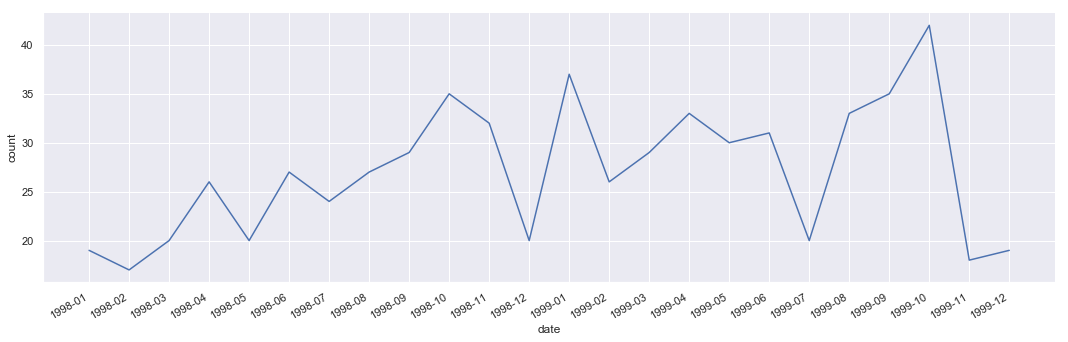

In [426]:
# visualize the monthly number of published movies
year_month_count_df = df.groupby('yearMonth').count()['name'].reset_index()
year_month_count_df.columns = ['date', 'count']
g = sns.relplot(x="date", y="count", kind="line", data=year_month_count_df, aspect=3)
g.fig.autofmt_xdate()
g.savefig('year-month.png')

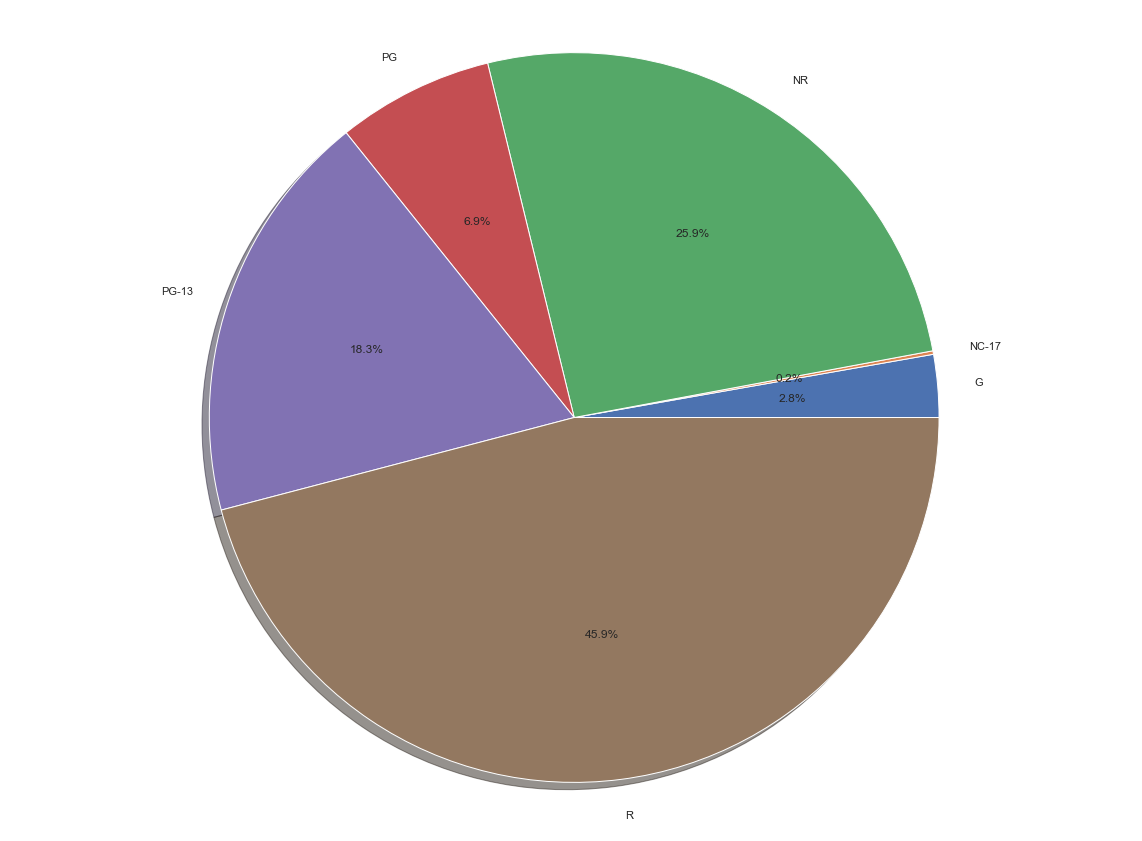

In [427]:
# visualize the percent rate of movies of different content rating
content_rating_count_df = df.groupby('contentRating').count()['name'].reset_index()
content_rating_count_df.columns = ['contentRating', 'count']
fig1, ax1 = plt.subplots(figsize=(20,15))
ax1.pie(content_rating_count_df['count'], labels=content_rating_count_df['contentRating'], 
        autopct='%1.1f%%', shadow=True)
ax1.axis('equal')
plt.show()
fig1.savefig('content-rating.png')

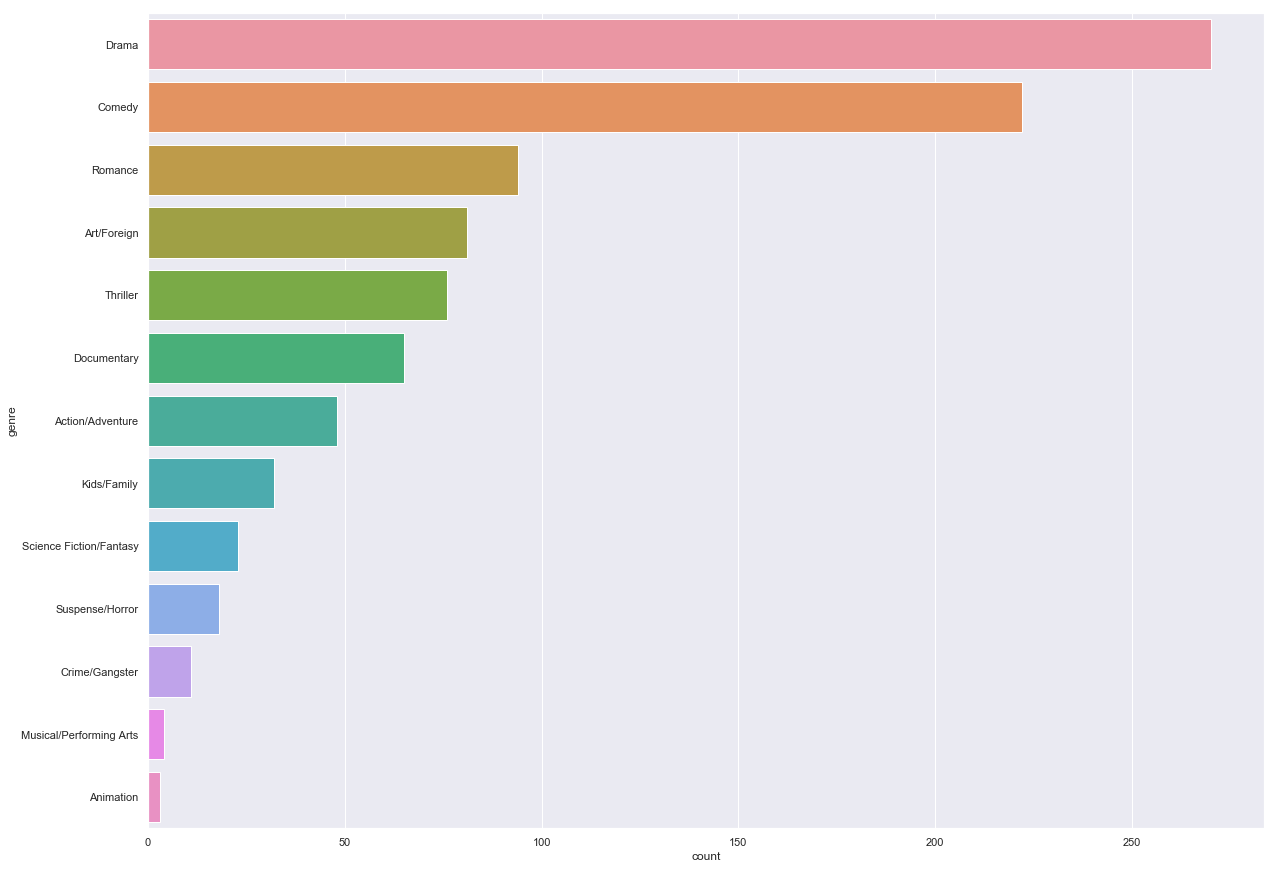

In [428]:
# visualize the number of movies of different genres
genre_set = set(sum(df['genre'].tolist(), []))
genre_dict = {}
for x in genre_set:
    genre_dict[x] = 0

for x in df['genre']:
    for y in genre_set:
        if y in x:
            genre_dict[y] += 1

genre_df = pd.DataFrame(genre_dict.items(), columns=['genre', 'count']).sort_values(by='count', ascending=False)
plt.subplots(figsize=(20,15))
ax = sns.barplot(x="count", y="genre", data=genre_df)
plt.savefig('genre.png')

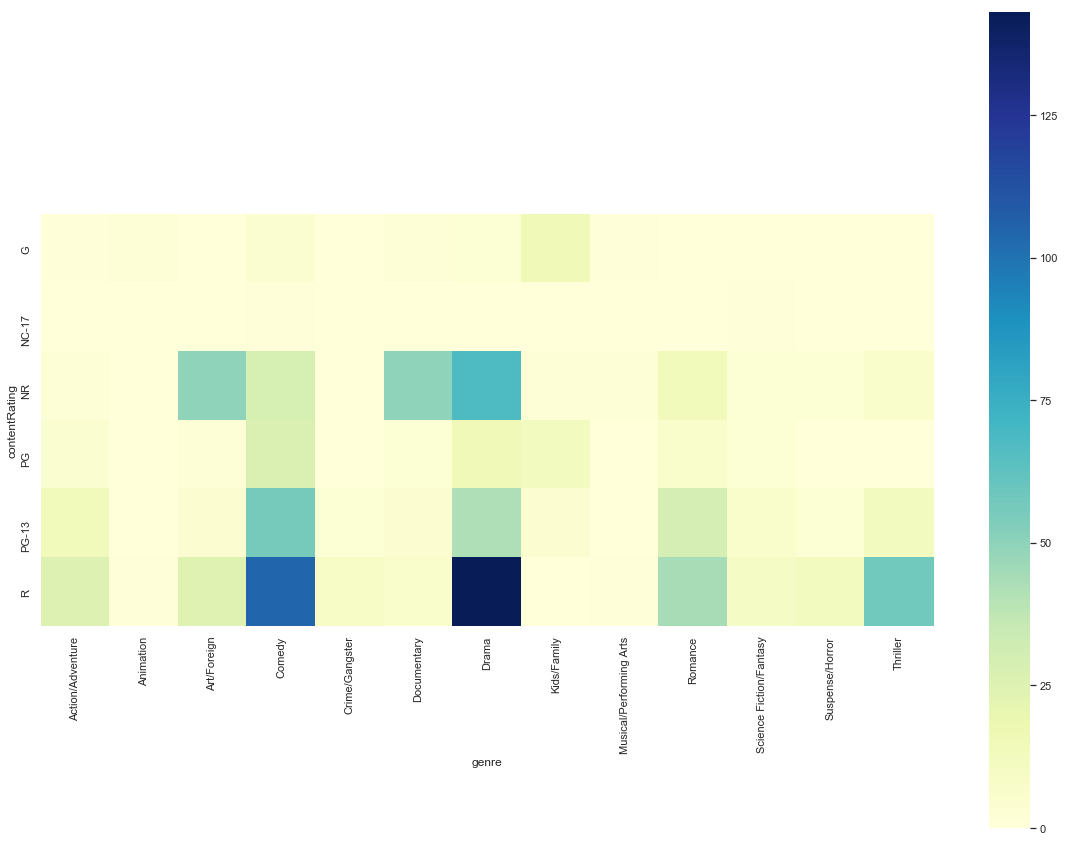

In [429]:
# visualize the correlation between content rating and genre
content_rating_genre_entries = []
for index, row in df.iterrows():
    for x in row['genre']:
        content_rating_genre_entries.append([row['name'], row['contentRating'], x])

content_rating_genre_df = pd.DataFrame(entries, columns=['name', 'contentRating', 'genre'])
content_rating_genre_df = content_rating_genre_df.groupby(['genre', 'contentRating']).count().reset_index()
content_rating_genre_pivot = content_rating_genre_df.pivot('contentRating','genre', 'name')
content_rating_genre_pivot = content_rating_genre_pivot.fillna(0)
plt.subplots(figsize=(20,15))
ax = sns.heatmap(data=content_rating_genre_pivot, square=True, cmap="YlGnBu")
plt.savefig('rating-genre.png')